In [1]:
%matplotlib widget
%config InlineBackend.figure_formats = ['svg']
import glob
import sys
import csv
import json
import statistics
from datetime import datetime
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

import numpy as np
import scipy.stats as st
from matplotlib.transforms import Affine2D
from joblib import Parallel, delayed

Declare global paths and variables

In [2]:
OUTER_LOG_DIR = "/home/vpatil/mn/work/log/8"

INVERTED_X = True
INV_CODE = 'inv' if INVERTED_X else 'p'
X_LABEL = 'Data items published per second' if INVERTED_X else 'Publishing Interval [s]'

NUM_NODES = 20

if INVERTED_X:
    # PUB_TIMING_VALS = [250, 375, 500, 750, 1000, 1500, 2000, 3000, 5000, 10000, 15000]
    PUB_TIMING_VALS = [500, 750, 1000, 1500, 2000, 3000, 5000, 10000, 15000]
else:
    PUB_TIMING_VALS = [1000, 1500, 2000, 3000, 4000, 5000, 7500, 10000, 12500, 15000]

RUN_NUMBER_VALS = list(range(1, 10))

#LOG_PREFIXES = ["chronosync-nj/GEANT_L0", "psync-lj/GEANT_L0", "syncps/GEANT_L0", "svs/GEANT_L0"]
#LOG_PREFIX_LABELS = ["ChronoSync", "PSync", "syncps", "SVS"]
#COLORS = ["red", "orange", "blue", "green"]
#MARKERS = ["^", "v", "o", "s"]

# =========== OVERALL ===========
#LOG_PREFIXES = ["chronosync-10/GEANT_L0", "psync-10/GEANT_L0", "syncps-10/GEANT_L0", "svs/GEANT_L0",
#               "chronosync-10/GEANT_L20", "psync-10/GEANT_L20", "syncps-10/GEANT_L20", "svs/GEANT_L20"]
LOG_PREFIXES = ["chronosync/GEANT_L0", "psync-1/GEANT_L0", "syncps/GEANT_L0", "svs/GEANT_L0",
               "chronosync/GEANT_L20", "psync-1/GEANT_L20", "syncps/GEANT_L20", "svs/GEANT_L20"]
LOG_PREFIX_LABELS = ["ChronoSync", "PSync", "syncps", "SVS", "ChronoSync", "PSync", "syncps", "SVS"]
COLORS = ["red", "orange", "blue", "green", "red", "orange", "blue", "green"]
MARKERS = ["^", "v", "o", "s", "^", "v", "o", "s"]

# proto = "syncps-10"
# proto_name = "syncps"
#LOG_PREFIXES = [proto + "/GEANT_L0", proto + "/GEANT_L5", proto + "/GEANT_L10", proto + "/GEANT_L20"]
#LOG_PREFIX_LABELS = [proto_name + " - No Loss", proto_name + " - 5% Loss",
#                     proto_name + " - 10% Loss", proto_name + " - 20% Loss"]
#COLORS = ["green", "blue", "orange", "red"]

# ========== SYNCPS PLOT ============
# proto = "syncps"
# proto_name = proto
# LOG_PREFIXES = [proto + "/GEANT_L0", proto + "/GEANT_L20", "chronosync-nj/GEANT_L0"]
# LOG_PREFIX_LABELS = ["No Loss", "20% Loss", ""]
# COLORS = ["blue", "green", "gray"]
# MARKERS = ["^", "o", "v"]
# ===================================

# ========== GENERAL PLOT ============
# proto = "svs"
# proto_name = proto
# LOG_PREFIXES = [proto + "/GEANT_L0", proto + "/GEANT_L20"]
# LOG_PREFIX_LABELS = ["No Loss", "20% Loss"]
# COLORS = ["blue", "green"]
# MARKERS = ["^", "o"]
# ===================================

#LOG_PREFIXES = ["chronosync/GEANT_L0", "chronosync/GEANT_L20", 'chronosync-ll/GEANT_L0', 'chronosync-ll/GEANT_L20']
#LOG_PREFIXES = ["psync-1/GEANT_L0", "psync-1/GEANT_L20", 'psync-lj/GEANT_L0', 'psync-lj/GEANT_L20']
#LOG_PREFIX_LABELS = ["No Loss [500ms]", "20% Loss [500ms]", "No Loss [100ms]", "20% Loss [100ms]"]
#MARKERS = ["^", "v", "o", "s"]

# =========== SVSPS =================
# LOG_PREFIXES = ["svs/GEANT_L0", "svs-prefetch/GEANT_L0", "syncps/GEANT_L0"]
# LOG_PREFIXES = ["svs/GEANT_L20", "svs-prefetch/GEANT_L20", "syncps/GEANT_L20"]
# LOG_PREFIX_LABELS = ["SVS", "SVS (prefetch)", "syncps"]
# COLORS = ["blue", "orange", "red", "green"]
# MARKERS = ["^", "o", "^", "o"]
# ===================================

Read routes

In [3]:
ROUTES = {}
with open('GEANT-routes.json') as f:
    ROUTES = json.load(f)

Process all log files

In [4]:
DATA_VARIABLES = [
    'TIMING_DATA',
    'TIMING_DATA_AVG',
    'TIMING_DATA_50',
    'TIMING_DATA_75',
    'TIMING_DATA_90',
    'PUBLISH_TIMES_DATA',
    'SYNC_INT_DATA',
    'SUCCESS_DATA',
    'SUCCESS_DATA_50',
    'SUCCESS_DATA_10',
    'SUPPRESSION_DATA',
    'NUM_PUBLISHED_DATA',
    'NUM_nInInterestsData',
]

def process_log(LOG_PREFIX):
    # Initialize variables
    for d in DATA_VARIABLES:
        globals()[d][LOG_PREFIX] = [[] for x in PUB_TIMING_VALS]

    for i_t, PUB_TIMING in enumerate(PUB_TIMING_VALS):
        RECEIVE_NODES_GLOB = defaultdict(list)
        
        for RUN_NUMBER in RUN_NUMBER_VALS:
            
            # exclusion
            #if 'syncps/' in LOG_PREFIX and (PUB_TIMING, RUN_NUMBER) in [(1000, 1),(1000, 5),(1000, 6)]:
                #continue
            #if 'syncps/' in LOG_PREFIX and (PUB_TIMING, RUN_NUMBER) in [(1000, 10)]:
                #continue
                
            if 'chronosync/GEANT_L20' in LOG_PREFIX and (PUB_TIMING, RUN_NUMBER) in [(750, 2),(750, 4),(750, 8)]:
                continue
            
            if 'chronosync/GEANT_L0' in LOG_PREFIX and (PUB_TIMING, RUN_NUMBER) in [(500, 10)]:
                continue
                
            if 'psync-lj/GEANT_L0' in LOG_PREFIX and (PUB_TIMING, RUN_NUMBER) in [(750, 1)]:
                continue
                
            if 'psync-lj/GEANT_L20' in LOG_PREFIX and (PUB_TIMING, RUN_NUMBER) in [(750, 1)]:
                continue

            PUBLISHING_NODES = []
            RECEIVE_NODES = defaultdict(int)

            # Let log directory and files
            LOG_NAME = "{}-{}-{}".format(LOG_PREFIX, PUB_TIMING, RUN_NUMBER)
            LOG_DIR = OUTER_LOG_DIR + '/' + LOG_NAME

            print("Processing", LOG_NAME)

            PUBLISHES = {}
            SYNCS = {}
            RECIEVES = {}
            SYNC_INTS = 0
            CODE_COUNTS = defaultdict(int)

            for logfile in glob.glob(LOG_DIR + "/*.log"):
                nodename = logfile.split('/')[-1].split('.')[0]
                
                with open(logfile) as f:
                    l_publisher = logfile.split('/')[-1].split('.')[0]
                    cf = csv.DictReader(f, fieldnames=['t', 'pid', 'tid', 'm'],
                                        quotechar='"', delimiter=',', quoting=csv.QUOTE_ALL,
                                        skipinitialspace=True)
                    for row in cf:
                        try:
                            t = datetime.strptime(row['t'], "%Y-%m-%d %H:%M:%S.%f")
                        except ValueError:
                            print(row)
                            continue
                        ti = int((t - datetime.utcfromtimestamp(0)).total_seconds() * 1000)
                        m = row['m'].split('::')
                        
                        CODE_COUNTS[m[0]] += 1

                        if 'PUBL_MSG' in m[0]:
                            if len(m) < 3:
                                print(m)
                                continue
                            PUBLISHES[m[2]] = ti
                            PUBLISH_TIMES_DATA[LOG_PREFIX][i_t].append(ti)
                            RECEIVE_NODES[l_publisher] += 1
                        if 'RECV_MSG' in m[0]:
                            continue
                        if 'RECV_STATE' in m[0]:
                            if "chronosync" in LOG_PREFIX:
                                m[1] = m[1].split('/')
                                m[1].pop()
                                m[1] = "/".join(m[1])

                            msg = "{}={}".format(m[1], m[2])
                            if msg not in RECIEVES:
                                RECIEVES[msg] = []
                            RECIEVES[msg].append(ti)
                            
                            RECEIVE_NODES[l_publisher] += 1
                        if 'SEND_SYNC_INT' in m[0]:
                            SYNC_INTS += 1

            local_timing_data = []

            for msg in RECIEVES:
                if msg not in PUBLISHES:
                    print(msg, 'was received and never published :)')
                    continue

                pubtime = PUBLISHES[msg]
                recv_times = RECIEVES[msg]

                deltas = [x - pubtime for x in recv_times]
                publisher = msg.split('/')[3]
                if publisher not in PUBLISHING_NODES:
                    PUBLISHING_NODES.append(publisher)

                # Store global and local timing values
                TIMING_DATA[LOG_PREFIX][i_t].extend(deltas)
                local_timing_data.extend(deltas)
                
            kk = {}
            for psh in PUBLISHING_NODES:
                RECEIVE_NODES_GLOB[psh].append(RECEIVE_NODES[psh] / len(PUBLISHES))
                kk[psh] = round(RECEIVE_NODES[psh] / len(PUBLISHES), 2)
            #print(np.average(local_timing_data))

            # Get percentile global timing values
            TIMING_DATA_AVG[LOG_PREFIX][i_t].append(np.average(local_timing_data))
            TIMING_DATA_50[LOG_PREFIX][i_t].append(np.percentile(local_timing_data, 50))
            TIMING_DATA_75[LOG_PREFIX][i_t].append(np.percentile(local_timing_data, 75))
            TIMING_DATA_90[LOG_PREFIX][i_t].append(np.percentile(local_timing_data, 90))

            # Other metrics
            SYNC_INT_DATA[LOG_PREFIX][i_t].append(SYNC_INTS / len(PUBLISHES))
            #SUCCESS_DATA[LOG_PREFIX][i_t].append((len([x for k in RECIEVES for x in RECIEVES[k]]) / (NUM_NODES - 1)) / len(PUBLISHES))

            SUCCESS_DATA[LOG_PREFIX][i_t].append((len([1 for k in RECIEVES if len(RECIEVES[k]) == NUM_NODES - 1])) / len(PUBLISHES))

            #SUCCESS_DATA_50[LOG_PREFIX][i_t].append(np.percentile(np.fromiter(kk.values(), dtype=float), 50))
            #SUCCESS_DATA_10[LOG_PREFIX][i_t].append(np.percentile(np.fromiter(kk.values(), dtype=float), 10))
            SUCCESS_DATA_50[LOG_PREFIX][i_t].append(np.percentile([len(RECIEVES[msg])/(NUM_NODES - 1) for msg in RECIEVES], 50))
            SUCCESS_DATA_10[LOG_PREFIX][i_t].append(np.percentile([len(RECIEVES[msg])/(NUM_NODES - 1) for msg in RECIEVES], 10))
            
            NUM_PUBLISHED_DATA[LOG_PREFIX][i_t].append(len(PUBLISHES))

            nInInterests = 0
            nInData = 0
            packetData = []
            for startfile in glob.glob(LOG_DIR + "/report-start-*.status"):
                nodename = startfile.split('/')[-1].split('.')[0].split('-')[-1]
                endfile = startfile.replace('report-start', 'report-end')

                def read_status_file(filename):
                    status = {}
                    with open(filename, "r") as sf:
                        for line in sf.readlines():
                            if "Channels" in line:
                                break

                            if "=" in line:
                                line = line.strip()
                                v = line.split('=')
                                try:
                                    status[v[0]] = int(v[1])
                                except ValueError:
                                    status[v[0]] = v[1]
                    return status

                start = read_status_file(startfile)
                end = read_status_file(endfile)

                nInInterests += end['nInInterests'] - start['nInInterests']
                nInData += end['nInData'] - start['nInData']
                packetData.append(end['nInInterests'] - start['nInInterests'] + end['nInData'] - start['nInData'])

            NUM_nInInterestsData[LOG_PREFIX][i_t].append((nInInterests + nInData) / (len(PUBLISHES) * 45))
            #NUM_nInInterestsData[LOG_PREFIX][i_t].append(np.percentile(packetData, 50) / (len(PUBLISHES)))

            '''
            # Average latency calculation
            LATENCIES = []
            for node1 in PUBLISHING_NODES:
                for node2 in PUBLISHING_NODES:
                    if node1 == node2:
                        continue
                    LATENCIES.append(ROUTES[node1][node2])
            print(sum(LATENCIES)/len(LATENCIES))
            '''
            
            if 'proto' in vars() and proto == "svs":
                suppression_percent = CODE_COUNTS['SYNC_REPLY_SUPPRESSED'] / (CODE_COUNTS['SYNC_REPLY_SENT_NO_RECORD'] + CODE_COUNTS['SYNC_REPLY_SENT_RECORD_OLD'] + CODE_COUNTS['SYNC_REPLY_SUPPRESSED'])
                SUPPRESSION_DATA[LOG_PREFIX][i_t].append(suppression_percent)
        
        #RECEIVE_NODES_GLOB = {k: len(v) for k, v in RECEIVE_NODES_GLOB.items()}
        #print({k: round(v, 2) for k, v in sorted(RECEIVE_NODES_GLOB.items(), key=lambda item: item[1])})
        #print(RECEIVE_NODES_GLOB)

    print("Done", LOG_PREFIX)

    return dict((d, globals()[d][LOG_PREFIX]) for d in DATA_VARIABLES)    

In [5]:
for d in DATA_VARIABLES:
    globals()[d] = {}

In [6]:
res = Parallel(n_jobs=8, backend='multiprocessing')(delayed(process_log)(PREFIX) for PREFIX in LOG_PREFIXES)

for i, PREFIX in enumerate(LOG_PREFIXES):
    for d in DATA_VARIABLES:
        globals()[d][PREFIX] = res[i][d]

ProcessingProcessingProcessingProcessingProcessing Processing  ProcessingProcessing  chronosync/GEANT_L0-500-1 psync-1/GEANT_L0-500-1syncps/GEANT_L0-500-1  chronosync/GEANT_L20-500-1svs/GEANT_L0-500-1
psync-1/GEANT_L20-500-1

syncps/GEANT_L20-500-1
svs/GEANT_L20-500-1



Processing syncps/GEANT_L20-500-2
Processing syncps/GEANT_L0-500-2
Processing syncps/GEANT_L20-500-3
Processing syncps/GEANT_L0-500-3
Processing psync-1/GEANT_L0-500-2
Processing psync-1/GEANT_L20-500-2
Processing chronosync/GEANT_L0-500-2
Processing chronosync/GEANT_L20-500-2
Processing syncps/GEANT_L20-500-4
Processing syncps/GEANT_L0-500-4
Processing svs/GEANT_L0-500-2
Processing svs/GEANT_L20-500-2
Processing syncps/GEANT_L20-500-5
Processing syncps/GEANT_L0-500-5
Processing psync-1/GEANT_L0-500-3
Processing psync-1/GEANT_L20-500-3
Processing syncps/GEANT_L20-500-6
Processing syncps/GEANT_L0-500-6
Processing chronosync/GEANT_L0-500-3
Processing chronosync/GEANT_L20-500-3
Processing syncps/GEANT_L20-500-7
Processing

Processing psync-1/GEANT_L0-1000-5
Processing syncps/GEANT_L0-15000-7
Processing syncps/GEANT_L20-3000-8
Processing syncps/GEANT_L0-15000-8
Processing syncps/GEANT_L0-15000-9
Done syncps/GEANT_L0
Processing psync-1/GEANT_L20-1000-5
Processing chronosync/GEANT_L0-1000-1
Processing syncps/GEANT_L20-3000-9
Processing chronosync/GEANT_L20-1000-5
Processing syncps/GEANT_L20-5000-1
Processing svs/GEANT_L0-750-5
Processing psync-1/GEANT_L0-1000-6
Processing syncps/GEANT_L20-5000-2
Processing syncps/GEANT_L20-5000-3
Processing psync-1/GEANT_L20-1000-6
Processing syncps/GEANT_L20-5000-4
Processing svs/GEANT_L20-750-5
Processing chronosync/GEANT_L0-1000-2
Processing syncps/GEANT_L20-5000-5
Processing syncps/GEANT_L20-5000-6
Processing chronosync/GEANT_L20-1000-6
Processing psync-1/GEANT_L0-1000-7
Processing syncps/GEANT_L20-5000-7
Processing syncps/GEANT_L20-5000-8
Processing psync-1/GEANT_L20-1000-7
Processing syncps/GEANT_L20-5000-9
Processing syncps/GEANT_L20-10000-1
Processing chronosync/GEA

Processing chronosync/GEANT_L20-3000-8
Processing psync-1/GEANT_L20-15000-7Processing
 svs/GEANT_L0-1000-8
Processing psync-1/GEANT_L20-15000-8
Processing psync-1/GEANT_L20-15000-9
Done psync-1/GEANT_L20
Processing chronosync/GEANT_L20-3000-9
Processing chronosync/GEANT_L0-2000-8
Processing chronosync/GEANT_L20-5000-1
Processing svs/GEANT_L20-1000-8
Processing chronosync/GEANT_L0-2000-9
Processing chronosync/GEANT_L20-5000-2
Processing chronosync/GEANT_L20-5000-3
Processing svs/GEANT_L0-1000-9
Processing chronosync/GEANT_L0-3000-1
Processing chronosync/GEANT_L20-5000-4
Processing chronosync/GEANT_L20-5000-5
Processing chronosync/GEANT_L0-3000-2
Processing chronosync/GEANT_L20-5000-6
Processing svs/GEANT_L20-1000-9
Processing chronosync/GEANT_L0-3000-3
Processing chronosync/GEANT_L20-5000-7
Processing chronosync/GEANT_L20-5000-8
Processing chronosync/GEANT_L0-3000-4
Processing svs/GEANT_L0-1500-1
Processing chronosync/GEANT_L20-5000-9
Processing chronosync/GEANT_L0-3000-5
Processing chr

In [7]:
PUB_TIMING_VALS_SEC = [x/1000 for x in PUB_TIMING_VALS]
#process_log('chronosync-nj/GEANT_L0')

## Graphs

For each value of publishing timings, the experiment runs for the same amount of time regardless of the loss rate. The differences in the values indicate the randomness of the experiment (on the client).

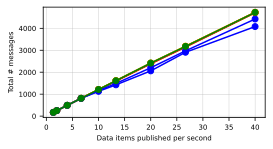

In [8]:
plt.rcParams.update({'font.size': 7})

fig, ax = plt.subplots()
#ax.set_title('Total # of messages published')
ax.set_ylabel('Total # messages')
ax.set_xlabel('Data items published per second')
#ax.set_xticks([1,5,10,15])

xvals = PUB_TIMING_VALS_SEC
if INVERTED_X:
    xvals = (1./np.array(xvals))*NUM_NODES

for i, LOG_PREFIX in enumerate(LOG_PREFIXES):
    data = [sum(x)/len(x) for x in NUM_PUBLISHED_DATA[LOG_PREFIX]]
    ax.plot(xvals, data, '-o', label=LOG_PREFIX_LABELS[i], color=COLORS[i])
    
#ax.legend()
ax.grid(linewidth=0.3)

fig.set_size_inches(4, 2)
display(fig)
plt.savefig('msgs.pdf', bbox_inches='tight', pad_inches=0.02)
plt.close()

In [9]:
def do_plots(glob_data, ax, ninety=False, fmt='-', label=None,
             prefixes=LOG_PREFIXES, prefix_labels=LOG_PREFIX_LABELS, colors=COLORS, markers=MARKERS):
    if label is not None and label != '':
            label = label + '; '

    for i, LOG_PREFIX in enumerate(prefixes):
        data = glob_data[LOG_PREFIX]
        
        #d = [np.percentile(x, 50) for x in data]
        #yu = np.abs([np.percentile(x, 75) for x in data] - np.array(d))
        #yl = np.abs([np.percentile(x, 25) for x in data] - np.array(d))
        
        d = [np.mean(x) for x in data]
        yl, yu = zip(*[st.t.interval(0.95, len(x)-1, loc=np.mean(x), scale=st.sem(x)) for x in data])
        yu = np.abs(np.array(yu) - np.array(d))
        yl = np.abs(np.array(yl) - np.array(d))

        trans = Affine2D().translate(-0.2+0.2 * i, 0.0) + ax.transData
        trans = None

        xvals = PUB_TIMING_VALS_SEC
        if INVERTED_X:
            xvals = (1./np.array(xvals))*NUM_NODES
        
        ax.errorbar(xvals, d, yerr=[yl, yu],
                    fmt=fmt+markers[i], color=colors[i], transform=trans,
                    solid_capstyle='projecting', capsize=4,
                    linewidth=1,markersize=3,capthick=0.75,
                    label=label+prefix_labels[i] if label is not None else None)
        
        if not INVERTED_X:
            ax.set_xticks([1,5,10,15])

        if ninety:
            ax.plot(PUB_TIMING_VALS_SEC, [np.percentile(x, 90) for x in data], ':', 
                    color=colors[i], transform=trans)

### Timing Plots

Time to delivery - dashed lines represent the 75th percentile (where applicable) and dotted lines represent the 90th percentile. The error bars indicate the 25th and 75th percentiles in the plot below.

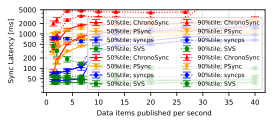

In [10]:
IS_SYNCPS = True and 'proto' in vars() and 'syncps' in proto

fig, ax = plt.subplots()

if IS_SYNCPS:
    fig, (ax, ax2) = plt.subplots(nrows=2, sharex=True)
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
else:
    ax.set_xlabel(X_LABEL)

#ax.set_title('Message Delivery Time')
ax.set_ylabel('Sync Latency [ms]')

ax.set_yscale('log')
yticks = [50, 100, 200, 500, 1000, 2000, 5000, 12000, 30000, 80000]
ax.set_yticks(yticks)
ax.set_yticklabels(yticks)

#do_plots(TIMING_DATA_AVG, ax, fmt='-', label='Avg.')

if not IS_SYNCPS:
    do_plots(TIMING_DATA_50, ax, fmt='-', label='50%tile')
    do_plots(TIMING_DATA_90, ax, fmt=':', label='90%tile')

    #ax.legend(bbox_to_anchor=(1.05, -0.22), frameon=False, ncol=2, prop={'size': 7})
    ax.legend(ncol=2, prop={'size': 6})
    #ax.legend(bbox_to_anchor=(0.5, -0.52), ncol=2, loc='lower center', prop={'size': 6}, frameon=False)
else:
    do_plots(TIMING_DATA_50, ax, fmt='-', label='50%tile', prefixes=LOG_PREFIXES[:2])
    do_plots(TIMING_DATA_90, ax, fmt=':', label='90%tile', prefixes=LOG_PREFIXES[:2])

    #ax.legend(bbox_to_anchor=(1.01, -1.37), frameon=False, ncol=2, prop={'size': 6})
    ax.legend(ncol=2, prop={'size': 6}, loc=4)
    ax2.grid(linewidth=0.3)
    
    ax12 = ax.twiny()
    do_plots(TIMING_DATA_90, ax12, fmt=":", label="", prefixes=LOG_PREFIXES[2:], prefix_labels=["ChronoSync; 90%tile\nNo Loss; No Jitter"], colors=["gray"], markers=['v'])
    ax12.legend(ncol=2, prop={'size': 5}, loc=2)
    ax12.tick_params(top=False, labeltop=False, left=False, labelleft=False, right=False, labelright=False, bottom=False, labelbottom=False)
    ax.tick_params(top=False, labeltop=False, right=False, labelright=False, bottom=False, labelbottom=False)
    ax.set_ylim(30, 6000)
    
ax.grid(linewidth=0.3)

if 'proto' not in vars():
    ax.set_ylim(20, 5000)

#ax.set_ylim(bottom=200)

if IS_SYNCPS:
    fig.set_size_inches(4, 3)
else:
    fig.set_size_inches(4, 1.5)
    #plt.rcParams.update({'font.size': 9})
    #fig.set_size_inches(6, 3)

# Set to true for delivery plot
if False:
    if not IS_SYNCPS:
        ax2 = ax
    ax2.clear()
    # Subplot fo delivery succses
    plt.subplots_adjust(hspace=.05)
    ax2.set_ylabel('Data items received\n by all participants [%]')
    ax2.set_xlabel(X_LABEL)
    s = {}
    for k, v in SUCCESS_DATA.items():
        s[k] = np.array(v) * 100
    # only first two prefixes for syncps, no chrono
    pfxs = LOG_PREFIXES[:2] if IS_SYNCPS else LOG_PREFIXES
    do_plots(s, ax2, fmt='-', label="", prefixes=pfxs)

    #do_plots(SUCCESS_DATA_50, ax2, fmt='-', label="50%tile")
    #do_plots(SUCCESS_DATA_10, ax2, fmt=':', label="90%tile")
    print(SUCCESS_DATA[proto+'/GEANT_L0'][2])
    
    ax2.legend(prop={'size': 6}, ncol=2)
    ax2.set_ylim(-5, 105)
    ax2.set_yscale('linear')
    ax2.set_yticks(np.array([0, 0.2, 0.4, 0.6, 0.8, 1.0])*100)
    ax2.grid(linewidth=0.3)

#########
if False:
    s={}
    for k, v in SUCCESS_DATA.items():
        mm = np.array(v) * 100
        for i, m in enumerate(mm):
            mm[i] = [np.average(mm[i])]
        s[k] = mm
    print(s['svs/GEANT_L20'])
    ax.clear()
    do_plots(s, ax, fmt='-', label="")
    ax.legend(prop={'size': 6}, ncol=2)
    ax.set_yticks(np.array([0, 0.2, 0.4, 0.6, 0.8, 1.0])*100)
    ax.set_ylabel('Data items received\n by all participants [%]')
#########
    
display(fig)

if 'proto' in vars():
    plt.savefig('eval-'+INV_CODE+'-'+proto_name+".pdf", bbox_inches='tight', pad_inches=0.02)
plt.savefig('eval-latency.pdf', bbox_inches='tight', pad_inches=0.02)

plt.close()

### Network Traffic

Total number of interests received by the network for every message published. This is for all the nodes including those not participating in sync, and is calculated using NFDC.

Note that this also includes data interests.

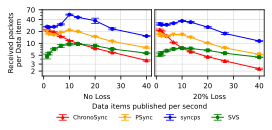

In [23]:
SHORT_FIG= True
#fig, ax = plt.subplots()
fig, (ax, ax2) = plt.subplots(ncols=2, sharey=True)
ax2.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

#ax.set_title('Network received packets per publish')
ax.set_ylabel('Received packets per Data item' if not SHORT_FIG else 'Received packets\nper Data item')
ax.set_xlabel('No Loss')
ax.set_yscale('log')
ax2.set_xlabel('20% Loss')

if SHORT_FIG:
    fig.text(0.5, -0.27, X_LABEL, ha='center')
else:
    fig.text(0.5, -0.12, X_LABEL, ha='center')

do_plots(NUM_nInInterestsData, ax, prefixes=LOG_PREFIXES[:4], label="")
do_plots(NUM_nInInterestsData, ax2, prefixes=LOG_PREFIXES[4:])

bbox = None
if SHORT_FIG:
    bbox = (1.85, -0.51)
ax.legend(bbox_to_anchor=bbox, frameon=not bbox, prop={'size': 5.8}, markerscale=0.7, ncol=4 if SHORT_FIG else 1)

yticks = [2, 3, 5, 10, 15, 25, 40, 60, 100]
if SHORT_FIG:
    yticks = [2, 3, 5, 10, 20, 40, 70]
    
ax.set_yticks(yticks)
ax.set_yticklabels(yticks)

ax.grid(linewidth=0.3)
ax2.grid(linewidth=0.3)

if INVERTED_X:
    xticks = np.array([0, 10, 20, 30, 40]).astype(int)
    ax.set_xticks(xticks)
    ax2.set_xticks(xticks)

if 'proto' not in vars():
    ax.set_ylim(1.5, 70)

plt.subplots_adjust(wspace=.03)

fig.set_size_inches(4, 1.2 if SHORT_FIG else 2)

display(fig)

if 'proto' not in vars():
    plt.savefig("eval-"+INV_CODE+"-overhead.pdf", bbox_inches='tight', pad_inches=0.02)
plt.savefig("comp-overhead.pdf", bbox_inches='tight', pad_inches=0.02)
plt.close('all')

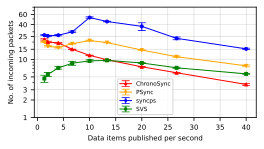

In [12]:
fig, ax = plt.subplots()

#ax.set_title('Network received packets per publish')
ax.set_ylabel('No. of incoming packets')
ax.set_xlabel(X_LABEL)
ax.set_yscale('log')

do_plots(NUM_nInInterestsData, ax, prefixes=LOG_PREFIXES[:4], label="")
#do_plots(NUM_nInInterestsData, ax2, prefixes=LOG_PREFIXES[4:])
ax.legend(prop={'size': 5.8}, markerscale=0.7)

yticks = [1, 2, 3, 5, 10, 15, 25, 40, 60, 100]
ax.set_yticks(yticks)
ax.set_yticklabels(yticks)

ax.grid(linewidth=0.3)
ax2.grid(linewidth=0.3)

if INVERTED_X:
    xticks = np.array([0, 5, 10, 15, 20, 25, 30, 35, 40]).astype(int)
    ax.set_xticks(xticks)
    ax2.set_xticks(xticks)

if 'proto' not in vars():
    ax.set_ylim(1, 80)

plt.subplots_adjust(wspace=.03)

fig.set_size_inches(4, 2)

display(fig)

plt.savefig("eval-"+INV_CODE+"-overhead-sin.pdf", bbox_inches='tight', pad_inches=0.02)
plt.close('all')

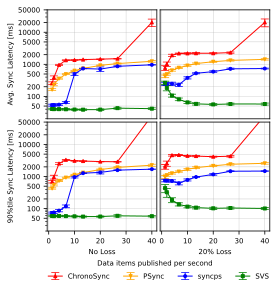

In [13]:
#fig, ax = plt.subplots()
fig, axg = plt.subplots(nrows=2, ncols=2, sharey=True, sharex=True)
ax, ax2 = axg[0]
ax3, ax4 = axg[1]

ax2.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax4.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

ax3.set_xlabel('No Loss')
ax4.set_xlabel('20% Loss')

ax.set_ylabel('Avg. Sync Latency [ms]')
ax3.set_ylabel('90%tile Sync Latency [ms]')
ax.set_yscale('log')
yticks = [50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000]
ax.set_yticks(yticks)
ax.set_yticklabels(yticks)

fig.text(0.5, -0.01, X_LABEL, ha='center')

do_plots(TIMING_DATA_AVG, ax, prefixes=LOG_PREFIXES[:4], label='')
do_plots(TIMING_DATA_AVG, ax2, prefixes=LOG_PREFIXES[4:], label='')
do_plots(TIMING_DATA_90, ax3, prefixes=LOG_PREFIXES[:4])
do_plots(TIMING_DATA_90, ax4, prefixes=LOG_PREFIXES[4:])
#ax2.legend(fontsize='x-small',markerscale=1)
ax2.legend(bbox_to_anchor=(1.05, -1.36), frameon=False, ncol=4, prop={'size': 7},loc='upper right')
if 'proto' not in vars():
    ax.set_ylim(20, 6000)
    
if INVERTED_X:
    xticks = np.array([0, 10, 20, 30, 40]).astype(int)
    ax.set_xticks(xticks)
    ax2.set_xticks(xticks)
    
ax.set_ylim(20, 50000)
ax.grid(linewidth=0.3)
ax2.grid(linewidth=0.3)
ax3.grid(linewidth=0.3)
ax4.grid(linewidth=0.3)
plt.subplots_adjust(wspace=.03,hspace=.03)

fig.set_size_inches(4, 4)

display(fig)

plt.savefig("eval-" + INV_CODE + "-latency.pdf", bbox_inches='tight', pad_inches=0.02)
plt.close()

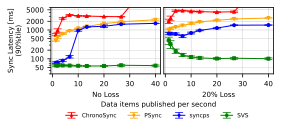

In [24]:
#fig, ax = plt.subplots()
fig, (ax, ax2) = plt.subplots(ncols=2, sharey=True)
ax2.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

#ax.set_title('Network received packets per publish')
ax.set_ylabel('90%tile Sync Latency [ms]' if not SHORT_FIG else 'Sync Latency [ms]\n(90%tile)')
ax.set_xlabel('No Loss')
ax.set_yscale('log')
ax2.set_xlabel('20% Loss')
if SHORT_FIG:
    fig.text(0.5, -0.27, X_LABEL, ha='center')
else:
    fig.text(0.5, -0.12, X_LABEL, ha='center')

do_plots(TIMING_DATA_90, ax, prefixes=LOG_PREFIXES[:4], label="")
do_plots(TIMING_DATA_90, ax2, prefixes=LOG_PREFIXES[4:])

bbox = None
if SHORT_FIG:
    bbox = (1.85, -0.51)
ax.legend(bbox_to_anchor=bbox, frameon=not bbox, prop={'size': 5.8}, markerscale=0.7, ncol=4 if SHORT_FIG else 1)

yticks = [50, 100, 200, 500, 1000, 2000, 5000]
ax.set_yticks(yticks)
ax.set_yticklabels(yticks)

ax.grid(linewidth=0.3)
ax2.grid(linewidth=0.3)

if INVERTED_X:
    xticks = np.array([0, 10, 20, 30, 40]).astype(int)
    ax.set_xticks(xticks)
    ax2.set_xticks(xticks)

if 'proto' not in vars():
    ax.set_ylim(30, 6000)

plt.subplots_adjust(wspace=.03)

fig.set_size_inches(4, 1.2 if SHORT_FIG else 2)

display(fig)

if 'proto' not in vars():
    plt.savefig("eval-"+INV_CODE+"-latency.pdf", bbox_inches='tight', pad_inches=0.02)
plt.savefig("comp-latency.pdf", bbox_inches='tight', pad_inches=0.02)
plt.close('all')

/tmp/ipykernel_536030/3314041138.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.multiply(data, NUM_PUBLISHED_DATA[LOG_PREFIX]) / 120


TypeError: can't multiply sequence by non-int of type 'list'

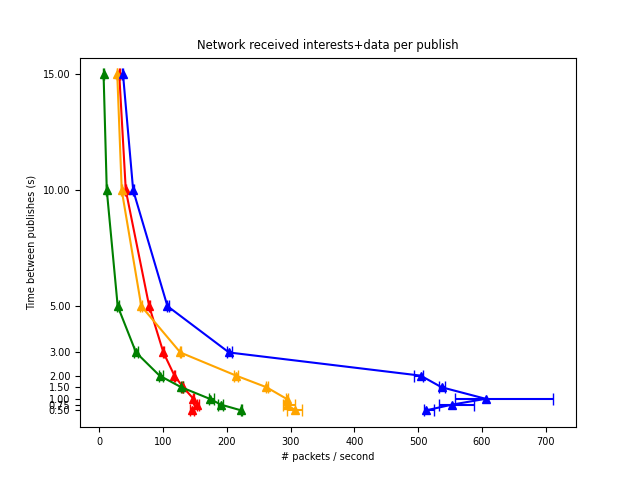

In [15]:
fig, ax = plt.subplots()
ax.set_title('Network received interests+data per publish')
ax.set_xlabel('# packets / second')
ax.set_ylabel('Time between publishes (s)')
ax.set_yticks(PUB_TIMING_VALS_SEC)

glob_data = NUM_nInInterestsData
for i, LOG_PREFIX in enumerate(LOG_PREFIXES):
    data = glob_data[LOG_PREFIX]
    data = np.multiply(data, NUM_PUBLISHED_DATA[LOG_PREFIX]) / 120
    d = [np.percentile(x, 50) for x in data]
    yu = np.abs([np.percentile(x, 75) for x in data] - np.array(d))
    yl = np.abs([np.percentile(x, 25) for x in data] - np.array(d))

    trans = Affine2D().translate(-0.2+0.2 * i, 0.0) + ax.transData
    ax.errorbar(d, PUB_TIMING_VALS_SEC, xerr=[yl, yu],
                fmt='-^', color=COLORS[i], transform=trans,
                solid_capstyle='projecting', capsize=4,
                label=LOG_PREFIX_LABELS[i])

ax.legend()
if 'proto' not in vars():
    ax.set_xlim(-1000, 30000)
display(fig)
plt.close()

Total fraction of messages delivered successfuly. This value may be affected by the convergence time provided at the end of each experiment. Some nodes may also randomly crash affecting the value.

In [ ]:
#fig, ax = plt.subplots()
fig, (ax, ax2) = plt.subplots(ncols=2, sharey=True)
ax2.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

ax.set_ylabel('Fraction Delivered')
ax.set_xlabel('No Loss')
ax.set_xticks([1,5,10,15])

ax2.set_xticks([1,5,10,15])
ax2.set_xlabel('20% Loss')
fig.text(0.5, -0.14, X_LABEL, ha='center')

do_plots(SUCCESS_DATA, ax, prefixes=LOG_PREFIXES[:4])
do_plots(SUCCESS_DATA, ax2, prefixes=LOG_PREFIXES[4:])
ax2.legend(fontsize='x-small',markerscale=1)
    
ax.set_ylim(0, 1.1)
ax.grid(linewidth=0.3)
ax2.grid(linewidth=0.3)
plt.subplots_adjust(wspace=.03)

#fig.set_size_inches(4, 2)
fig.set_size_inches(8, 4)

display(fig)

plt.savefig("latency-avg-p.pdf", bbox_inches='tight', pad_inches=0.02)
plt.close()

In [ ]:
for i, val in enumerate(PUB_TIMING_VALS):
    data = PUBLISH_TIMES_DATA[LOG_PREFIXES[0]][i].copy()
    data.sort()

    for i in range(len(data) - 1):
        data[i] = data[i+1] - data[i]
    data.pop()
    data.sort()

    fig, ax = plt.subplots()
    ax.set_title('Time between publishes ({} ms)'.format(val))
    ax.set_ylabel('Cumulative percentage')
    ax.set_xlabel('Time (ms)')
    ax.set_xlim(-5, 100)
    plt.step(data, np.arange(len(data)) / len(data))
    display(fig)

plt.close('all')

In [ ]:
if 'svs' in vars() and proto == 'svs':
    fig, ax = plt.subplots()
    ax.set_title('SVS Sync Reply Suppression')
    ax.set_ylabel('Fraction of replies suppressed')
    ax.set_xlabel('Time between publishes (s)')
    ax.set_xticks(PUB_TIMING_VALS_SEC)

    do_plots(SUPPRESSION_DATA, ax)
    ax.legend()
    display(fig)
    plt.close()